In [ ]:
# GOAL : What am I searching for ?
        # => To predict with the best possible accuracy (proba) an event (+/- xx% variation of close_price)
        # What for ?
            # => To be able to balance my portfolio (sell what should go down for what should go up)
            # => Sell crypto for Stable coin / Or buy crypto with Stable Coin
########

# Advices : 
    # Be careful to scaling, min / max can change in the future...

In [5]:
from IPython.display import Image
#Image(filename='Schema.jpg')

In [ ]:
# DONE Now
    # 1 / Industrialization : 
        # Dataset for TOP 20 cryptos + capacity to learn from top 20 and predict 1 : DONE !
    # 2 / Gérer le fait qu'on a des datasets déséquilibrés ? : OK
    # 3 / Gérer l'overfitting de ouf : OK

In [ ]:
# TODO Now :
    # 4 / Faire du gridsearch puis optimiser avec treshold - Lister tout ce que je veux tester :
        # -> Dataset 1-20-40 cryptos
        # -> Algo XGBoost, RandomForest, MLP
        # Différents y (increase / deacrease + due date):
            # +3h  : (+/-) 2.5 / 5% / 7.5% / 10%
            # +6h  : (+/-) 2.5 / 5% / 7.5% / 10%
            # +12h : (+/-) 5% / 7.5% / 10%
            # +1d  : (+/-) 5% / 7.5% / 10%
            # +2d  : (+/-) 5% / 7.5% / 10%
            # +3d  : (+/-) 5% / 10% / 15% / 20%
            # +7d  : (+/-) 10% / 20% / 30%
            # +15d : (+/-) 10% / 20% / 30% / 50%
            # +30d : (+/-) 10% / 20% / 30% / 50% / 100%
        
        # Différents paramètres des algo avec Gridsearch (optimiser precision) - différents selon algos
            # => Tous les exemples : https://www.programcreek.com/python/example/91151/sklearn.model_selection.GridSearchCV        
        # Rapport Global qui met en avant les meilleurs modèles et les paramètres qui ont permis de les obtenir !
        # Treshold
    
    # 5 / Construire algo de strategy backtest Buy / Sell + indicateur de stratégie (prendre en compte prévisions d'augmentation et prévisions de baisse)  
    
    # 6 / Une fois que j'ai fait tout ça :
        # lecture + recherche internet d'inspiration / travaux semblables 
        # Feature engineering : 
            # New :
                # Variance close price, volumes 3h, 6h, 12h, 24h, etc., more indicators on different scale
                # Mean 24h price
                # Mean 24h price - current price
            # Delete useless ? Do real feature engineering with data vizualisation, correlation, etc.
    
    # 7 / Others :
        # Serialize scikit learn model: http://scikit-learn.org/stable/modules/model_persistence.html
        # Use cross validation ?
        # Différents algo de scaling en preprocessing
        # Mieux comprendre ce qui est fait par l'algo, ex Randomforest, afficher arbre avec seuils, etc.
        
    # 8 / A terme je pourrais avoir :
        # Des modèles qui se mettent à jour automatiquement
        # Pleins de modèles utilisés à différentes échelles pour savoir si il faut vendre ou acheter ! 
            # cf. que faire en fonction des différentes probas
        # Show learning curve ? Precision / Recall curve Other metrics ? Jouer sur Treshold pour maximiser précision
        # Deploy Model in AWS (serverless, cf. tuto https://medium.com/@patrickmichelberger/how-to-deploy-a-serverless-machine-learning-microservice-with-aws-lambda-aws-api-gateway-and-d5b8cbead846
        # Use AWS for model fitting ?
    

In [1]:
from utils_csa import show_model_accuracy, save_obj, load_obj

import pandas.io.sql as psql
import pandas as pd
import numpy as np

from sqlalchemy import create_engine

from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

from pytz import timezone
from datetime import datetime, timedelta, date

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, precision_score


# Lib to calcul financial indicators https://github.com/mrjbq7/ta-lib
import talib

# Lib to import ipynb : https://pypi.org/project/import-ipynb/
import import_ipynb
import algocryptos_preprocessing as alg_preproc

from pprint import pprint

#np.set_printoptions(threshold='nan')

importing Jupyter notebook from algocryptos_preprocessing.ipynb


In [9]:
# ------------------ PARAMETERS ------------------ #
# ['y_+3h_value', 'y_+3h_classif',, 'y_+6h_value', 'y_+6h_classif', 'y_+12h_value', 'y_+12h_classif','y_+1d_value', 'y_+1d_classif', 'y_+2d_value', 'y_+2d_classif', 'y_+3d_value', 'y_+3d_classif', 'y_+7d_value', 'y_+7d_classif', 'y_+15d_value', 'y_+15d_classif', 'y_+30d_value', 'y_+30d_classif']
id_cryptocompare = "7605" # ether 7605
y_to_be_considered = 'y_+1d_classif'
close_price_increase_targeted = +5
dict_hours_labels  = {3:'3h', 6:'6h', 12:'12h', 24:'1d', 24*2:'2d', 24*3:'3d', 24*7:'7d', 24*15:'15d', 24*30:'30d'}

In [3]:
# ------------------ LOAD DATA FROM DATABASE ------------------ #

# ONE CRYPTO
#df = alg_preproc.get_global_dataset_for_crypto("236131")
#df2 = df.reset_index(drop=True)

# TOP N CRYPTOS
#dict_df = alg_preproc.get_global_datasets_for_top_n_cryptos(30)

# ------------------ LOAD DATA FROM FILE ------------------ #
#save_obj(dict_df, 'dict_df_2018_10_26')
dict_df = load_obj('dict_df_2018_10_26')
dict_df.keys()

dict_keys(['16713', '166390', '1182', '5031', '7605', '202330', '166503', '4614', '3808', '171986', '321992', '204788', '5038', '310829', '3807', '236131', '27368', '5324', '186277', '5285', '24854', '4432', '187440', '347235', '808414', '190978', '19745', '127356'])

In [10]:
# ------------------ PRE-PROCESSING : Calcul y + split data ------------------ #
columns_nb = 0
df_new_dict = {}
df_new_list = []

def calcul_values_of_y(df, dict_hours_labels, increase_target_pct):
    increase_target_pct = increase_target_pct / 100
    
    for key in dict_hours_labels:
        label_value = 'y_+' + dict_hours_labels[key] + '_value'
        label_classif = 'y_+' + dict_hours_labels[key] + '_classif'
        # calcul several y searched (value)
        df[label_value] = df.close_price.shift(-key)
        
        # perform calcul to use binary classification
        df[label_classif] = ((df[label_value] - df['close_price']) / df['close_price']) > increase_target_pct
    
    return df

def do_split_data(df_p, columns_nb_p):
    # separe x,y
    X = df_p.iloc[:,range(1, columns_nb_p)]
    y = df_p.iloc[:,range(columns_nb_p, len(df_p.columns))]

    # split data in training / validating / testing
    return train_test_split(X, y, random_state=0, shuffle=False)

# calcul y for each crypto
for key_id_cryptocompare, df_one_crypto in dict_df.items():
    # number of columns before adding y values - could be done once only
    columns_nb = len(df_one_crypto.columns)

    # calcul all y values we are interested in and add it to the dataframe
    df_one_crypto = calcul_values_of_y(df_one_crypto.copy(), dict_hours_labels, close_price_increase_targeted)

    # remove rows where y can't be calculed (need more data in the future)
    df_one_crypto.dropna(subset=list(df_one_crypto.iloc[:,range(columns_nb, len(df_one_crypto.columns))]), inplace=True)
    
    df_new_dict[key_id_cryptocompare] = df_one_crypto
    df_new_list.append(df_one_crypto)

# concat to get only one dataframe instead of a list of dataframes
df_global = pd.concat(df_new_list).sort_index()
df_global.reset_index(drop=True)

# All cryptos
X_train, X_test, y_train, y_test = do_split_data(df_global, columns_nb)

# The one to predict
X_train_one_crypto, X_test_one_crypto, y_train_one_crypto, y_test_one_crypto = do_split_data(df_new_dict[id_cryptocompare], columns_nb)
X_test = X_test_one_crypto
y_test = y_test_one_crypto

# TODO : To be used to avoid overitting : No tuning while using testing data, only validation
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

# ------------------ PRE-PROCESSING : Scaling Data ------------------ #
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
#X_train_scaled = X_train
#X_test_scaled = X_test

In [9]:
# -----------------------
# RANDOMGRIDSEARCH: RANDOM FOREST
# -----------------------
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, precision_score
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 25, stop = 90, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt'] # TODO : Change with numbers ?
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(4, 10, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
criterion = ['gini', 'entropy']

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}
pprint(random_grid)

scorers = {
    'precision_score': make_scorer(precision_score)
}
pprint(scorers)

#scorers = {
#    'precision_score': make_scorer(precision_score),
#    'recall_score': make_scorer(recall_score),
#    'accuracy_score': make_scorer(accuracy_score)
#}

{'bootstrap': [True, False],
 'criterion': ['gini', 'entropy'],
 'max_depth': [4, 5, 6, 7, 8, 10],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [25, 32, 39, 46, 53, 61, 68, 75, 82, 90]}
{'precision_score': make_scorer(precision_score)}


In [16]:
rf = RandomForestClassifier(random_state=0, class_weight="balanced")
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 20, cv = 5, verbose=20, random_state=0, n_jobs = 3,
                              scoring=scorers, refit='precision_score') #n_jobs = 3
# Fit the random search model
rf_random.fit(X_train_scaled, y_train[y_to_be_considered])
rf_random.best_params_

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=3)]: Done   1 tasks      | elapsed:  1.0min
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done   3 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done   4 tasks      | elapsed:  3.8min
[Parallel(n_jobs=3)]: Done   5 tasks      | elapsed:  3.9min
[Parallel(n_jobs=3)]: Done   6 tasks      | elapsed:  4.0min
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:  5.9min
[Parallel(n_jobs=3)]: Done   8 tasks      | elapsed:  6.0min
[Parallel(n_jobs=3)]: Done   9 tasks      | elapsed:  6.1min
[Parallel(n_jobs=3)]: Done  10 tasks      | elapsed:  9.6min
[Parallel(n_jobs=3)]: Done  11 tasks      | elapsed:  9.6min
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:  9.8min
[Parallel(n_jobs=3)]: Done  13 tasks      | elapsed: 11.3min
[Parallel(n_jobs=3)]: Done  14 tasks      | elapsed: 11.4min
[Parallel(n_jobs=3)]: Done  15 tasks      | elapsed: 11.5min
[Parallel(n_jobs=3)]: Done  16 tasks      | elapsed: 16.9min
[Parallel(n_jobs=3)]: Do

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=20, n_jobs=3,
          param_distributions={'n_estimators': [25, 44, 63, 83, 102, 122, 141, 161, 180, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 6, 8, 10, 11, 13, 15, 16, 18, 20, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=0, refit='precision_score',
          return_train_score='warn',
          scoring={'prec

----------------------------------------------------------
Results for algorithm : RandomForestClassifier - Train
----------------------------------------------------------

Confusion Matrix :
 [[111264     66]
 [ 21919   9179]]
Accuracy: 0.85


Other Metrics :

             precision    recall  f1-score   support

      False       0.84      1.00      0.91    111330
       True       0.99      0.30      0.46     31098

avg / total       0.87      0.85      0.81    142428

----------------------------------------------------------

f1=0.809 auc=0.920 ap=0.920


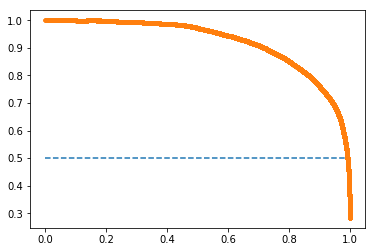

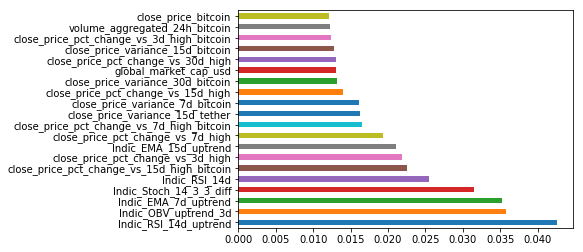

----------------------------------------------------------
Results for algorithm : RandomForestClassifier - Test
----------------------------------------------------------

Confusion Matrix :
 [[1574    1]
 [ 160   29]]
Accuracy: 0.91


Other Metrics :

             precision    recall  f1-score   support

      False       0.91      1.00      0.95      1575
       True       0.97      0.15      0.26       189

avg / total       0.91      0.91      0.88      1764

----------------------------------------------------------

f1=0.488 auc=0.631 ap=0.632


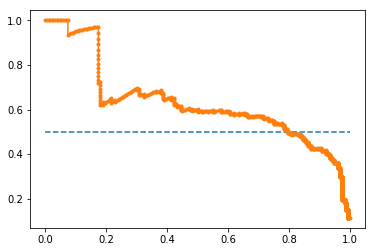

array([0.12156866, 0.12157915, 0.12213608, ..., 0.95308761, 0.954784  ,
       0.9563516 ])
{'bootstrap': False,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 11,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 83,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


In [5]:
# -----------------------
# ALGO : RANDOM FOREST
# -----------------------

from sklearn.ensemble import RandomForestClassifier
#, n_estimators=100, max_features='auto', max_depth=5, criterion='entropy', class_weight="balanced"
clf = RandomForestClassifier(random_state=0, class_weight="balanced", bootstrap=False,
 criterion='entropy',
 max_depth=11, #5
 max_features='auto',
 min_samples_leaf=4,
 min_samples_split=10,
 n_estimators=83).fit(X_train_scaled, y_train[y_to_be_considered])

show_model_accuracy('RandomForestClassifier - Train', clf, X_train_scaled, y_train[y_to_be_considered], X_train.columns, do_precision_recall_curve=True, do_features_importance=True, threshold=0.86)
show_model_accuracy('RandomForestClassifier - Test', clf, X_test_scaled, y_test[y_to_be_considered], X_test.columns, do_precision_recall_curve=True, do_features_importance=False, threshold=0.86)

# proba : to be shown by prediction, bien comprendre !
probas = clf.predict_proba(X_test_scaled)[:,1]
pprint(np.sort(probas))
pprint(clf.get_params())

# clf.decision_path(X_test)

----------------------------------------------------------
Results for algorithm : MLPClassifier - Neural Network - Train
----------------------------------------------------------

Confusion Matrix :
 [[77128  3956]
 [ 6557 14469]]
Accuracy: 0.90
AUC: 0.82


Other Metrics :

             precision    recall  f1-score   support

      False       0.92      0.95      0.94     81084
       True       0.79      0.69      0.73     21026

avg / total       0.89      0.90      0.89    102110

----------------------------------------------------------



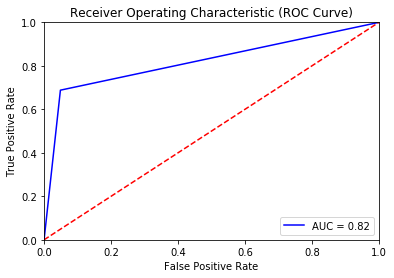

----------------------------------------------------------
Results for algorithm : MLPClassifier - Neural Network - Test
----------------------------------------------------------

Confusion Matrix :
 [[1476   94]
 [  69  118]]
Accuracy: 0.91
AUC: 0.79


Other Metrics :

             precision    recall  f1-score   support

      False       0.96      0.94      0.95      1570
       True       0.56      0.63      0.59       187

avg / total       0.91      0.91      0.91      1757

----------------------------------------------------------



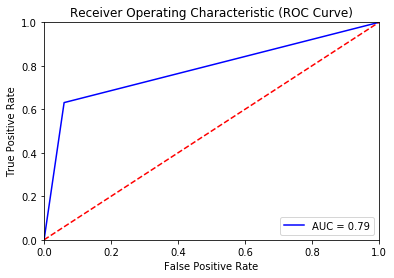

In [7]:
# -----------------------
# ALGO : MLPClassifier - Neural Network (cf. Module+4 for tuning)
# -----------------------
from sklearn.neural_network import MLPClassifier

nnclf = MLPClassifier(hidden_layer_sizes = [130, 130], solver='lbfgs',
                     random_state = 0).fit(X_train_scaled, y_train[y_to_be_considered])

show_model_accuracy('MLPClassifier - Neural Network - Train', nnclf, X_train_scaled, y_train[y_to_be_considered], X_train.columns, do_roc_curve=True, do_features_importance=False)
show_model_accuracy('MLPClassifier - Neural Network - Test', nnclf, X_test_scaled, y_test[y_to_be_considered], X_test.columns, do_roc_curve=True, do_features_importance=False)

# proba : to be shown by prediction, bien comprendre !
#print(pd.DataFrame(nnclf.predict_proba(X_test_scaled)[:,1]))

----------------------------------------------------------
Results for algorithm : GradientBoostingClassifier - Train
----------------------------------------------------------

Confusion Matrix :
 [[79039  2045]
 [10721 10305]]
Accuracy: 0.87
AUC: 0.73


Other Metrics :

             precision    recall  f1-score   support

      False       0.88      0.97      0.93     81084
       True       0.83      0.49      0.62     21026

avg / total       0.87      0.87      0.86    102110

----------------------------------------------------------



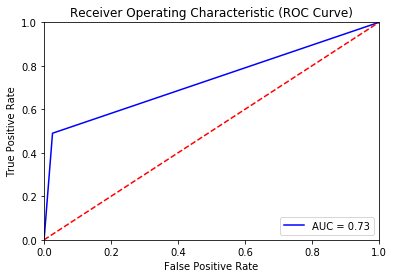

----------------------------------------------------------
Results for algorithm : GradientBoostingClassifier - Test
----------------------------------------------------------

Confusion Matrix :
 [[1517   53]
 [ 125   62]]
Accuracy: 0.90
AUC: 0.65


Other Metrics :

             precision    recall  f1-score   support

      False       0.92      0.97      0.94      1570
       True       0.54      0.33      0.41       187

avg / total       0.88      0.90      0.89      1757

----------------------------------------------------------



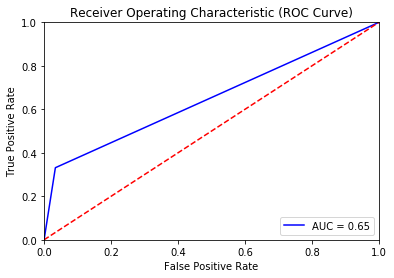

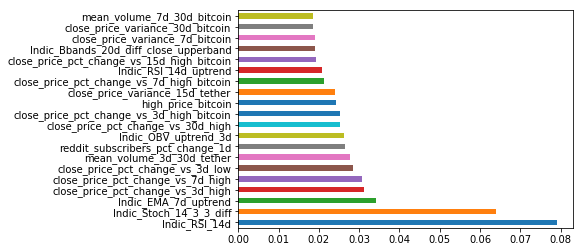

In [10]:
# -----------------------
# ALGO : GradientBoostingClassifier (cf. Module+4 for tuning)
# -----------------------
from sklearn.ensemble import GradientBoostingClassifier

#GradientBoostingClassifier(learning_rate = 0.02, max_depth = 5, random_state = 0)
clf = GradientBoostingClassifier().fit(X_train_scaled, y_train[y_to_be_considered])

show_model_accuracy('GradientBoostingClassifier - Train', clf, X_train_scaled, y_train[y_to_be_considered], X_train.columns, do_roc_curve=True, do_features_importance=False)
show_model_accuracy('GradientBoostingClassifier - Test', clf, X_test_scaled, y_test[y_to_be_considered], X_test.columns, do_roc_curve=True, do_features_importance=True)